In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. Load the Data and Exploratory Data Analysis (EDA)
    - inspect the dataset to understand features and targets

In [2]:
df = pd.read_csv("data/Loan_Default_kaggle.csv")
df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

## 1.1 Understand the data - basic checks
- check number of rows/column
- check dataset corruption    
    - unexpected data types
    - any missing values
    - non-sensical values (eg. Age = -1 or 999, Income = “abc)
    - one unique value columns
    - conflicting labeling (could be human labeling error)

In [3]:
# shape & types
print(df.shape)
print(df.info())
print(df.dtypes)

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

In [4]:
# preview the first few rows.
print("First 5 rows:")
print(df.head())

First 5 rows:
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758   

In [5]:
print("Last 5 rows:")
print(df.tail())

Last 5 rows:
            ID  year loan_limit             Gender approv_in_adv loan_type  \
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
148665           p3                l1        nopc                  nob/c  ...   
148666           p1                l1        nopc                  nob/c  ...   
148667           p4                l1        nopc                  nob/c  ...   
148668           p4                l1        nopc                  nob/c  ...   
148669           p3                l1        nopc                  nob/c  ...   

        credit_type  Credit_Sco

In [6]:
# check Non-sensical Values / Out-of-range
print(df.describe(include='all'))

                   ID      year loan_limit  Gender approv_in_adv loan_type  \
count   148670.000000  148670.0     145326  148670        147762    148670   
unique            NaN       NaN          2       4             2         3   
top               NaN       NaN         cf    Male         nopre     type1   
freq              NaN       NaN     135348   42346        124621    113173   
mean     99224.500000    2019.0        NaN     NaN           NaN       NaN   
std      42917.476598       0.0        NaN     NaN           NaN       NaN   
min      24890.000000    2019.0        NaN     NaN           NaN       NaN   
25%      62057.250000    2019.0        NaN     NaN           NaN       NaN   
50%      99224.500000    2019.0        NaN     NaN           NaN       NaN   
75%     136391.750000    2019.0        NaN     NaN           NaN       NaN   
max     173559.000000    2019.0        NaN     NaN           NaN       NaN   

       loan_purpose Credit_Worthiness open_credit business_or_c

Drop duplicates and remove columns that have one unique value

In [7]:
# Drop ID since it is just an identifier.
df = df.drop(columns=['ID'])

# Drop duplicates on features + targes
df = df.drop_duplicates()
print(df.shape)

constant_cols = df.columns[df.nunique(dropna=False) == 1]
print("Dropped constant columns:", list(constant_cols))
df = df.drop(columns=constant_cols)

(148670, 33)
Dropped constant columns: ['year']


Investigate conflicting rows (same features, different target)
conflict rows may indicate:
- Data entry error.
- Missing distinguishing features.
- Feature contains target info.

In [8]:
# Find rows with identical features but different targets
conflicts = df.groupby(list(df.columns.difference(['Status']))).agg({'Status': pd.Series.nunique})
conflicts = conflicts[conflicts['Status'] > 1]
print(conflicts)

Empty DataFrame
Columns: [Status]
Index: []


# 1.2 Split data into training dataset and testing dataset

In [9]:
# Identify features and target
target = 'Status'
features = df.columns.drop(target)

# Features only
X = df.drop(columns=[target])

# Target only
y = df[target]

# Optional: check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Features shape: (148670, 31)
Target shape: (148670,)


In [10]:
# define rules that use in training dataset that will be used in testing dataset
rules = {}

## 1.3 Visualize Distribution

Check the class ratio of target.
- if 1:1, balanced.
- if 6:4, slight imbalance.
- if 7:3, moderate imbalance.
- if 8:2 or worse, imbalance.
- if 9:1 or worse, seversely imbalance.

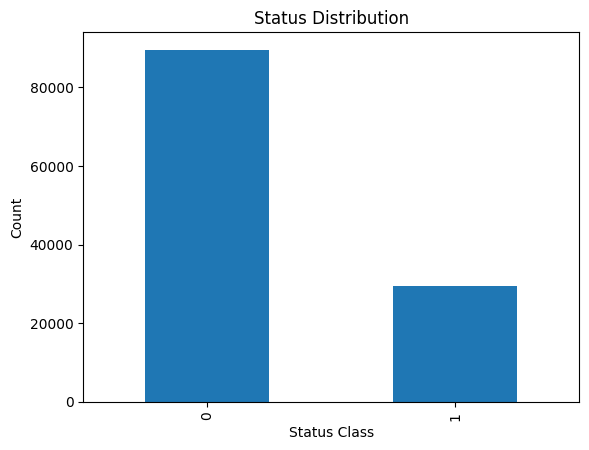

Ratio of 0 to  1:  3.05


In [11]:
def plot_target(y):
    y.value_counts().plot(kind='bar')
    plt.title("Status Distribution")
    plt.xlabel("Status Class")
    plt.ylabel("Count")
    plt.show()
plot_target(y_train)
class_counts = y_train.value_counts()
ratio_0_to_1 = class_counts[0] / class_counts[1]
print(f"Ratio of 0 to  1:  {ratio_0_to_1:.2f}")

It is a imbalanced data.

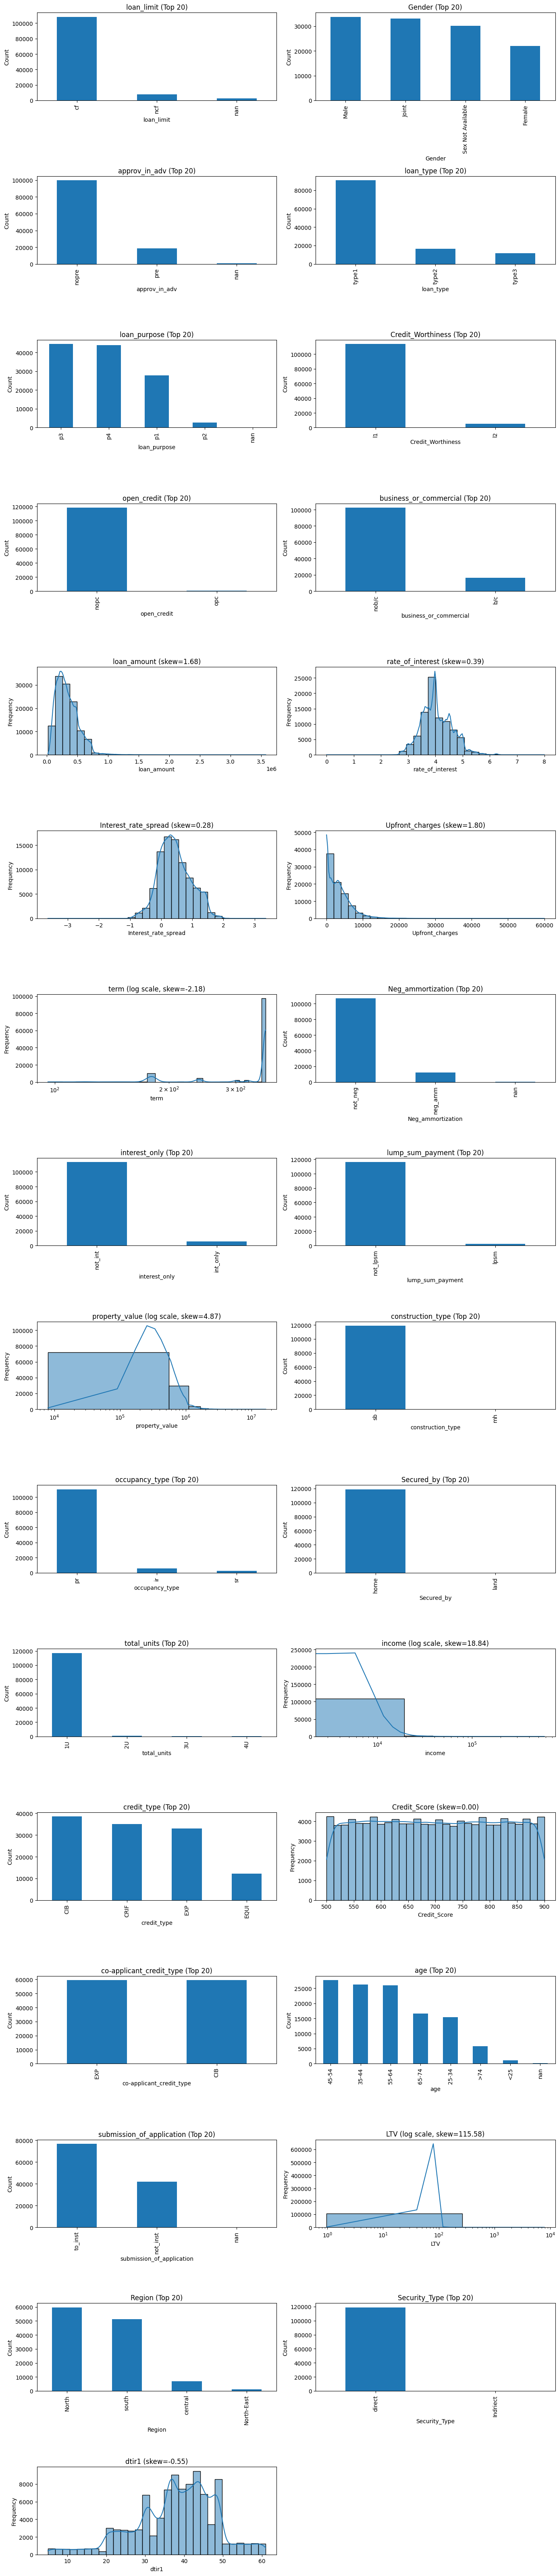

In [12]:
def plot_all_features_grid(df, top_n_categories=20, log_threshold_skew=2):
    num_cols = df.shape[1]
    n_cols = 2
    n_rows = int(np.ceil(num_cols / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(df.columns):
        ax = axes[idx]
        if pd.api.types.is_numeric_dtype(df[col]):
            skewness = df[col].skew(skipna=True)
            log_scale = abs(skewness) > log_threshold_skew
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
            if log_scale:
                ax.set_xscale('log')
                ax.set_title(f'{col} (log scale, skew={skewness:.2f})')
            else:
                ax.set_title(f'{col} (skew={skewness:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        else:
            vc = df[col].value_counts(dropna=False).head(top_n_categories)
            vc.plot(kind='bar', ax=ax)
            ax.set_title(f'{col} (Top {top_n_categories})')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_features_grid(X_train)  # Set to True to save plots

One dominant category – top category proportion ≥ threshold (e.g., 0.8)

Multiple frequent categories – low-cardinality, no single dominant category

High cardinality – many unique values (≥ threshold, e.g., 20)

In [13]:
def categorize_categorical_features(df, dominance_threshold=0.8, high_cardinality_threshold=20):
    """
    Classify categorical features into:
    - one dominant category
    - multiple frequent categories (low-cardinality)
    - high cardinality
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        dominance_threshold (float): Top category proportion to consider "dominant"
        high_cardinality_threshold (int): Number of unique categories to consider "high cardinality"
    
    Returns:
        dict: {'one_dominant': [...], 'multi_frequent': [...], 'high_cardinality': [...]}
    """
    one_dominant = []
    multi_frequent = []
    high_cardinality = []

    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        n_unique = df[col].nunique(dropna=False)
        counts = df[col].value_counts(normalize=True, dropna=False)
        top_prop = counts.iloc[0]

        if n_unique >= high_cardinality_threshold:
            high_cardinality.append(col)
        elif top_prop >= dominance_threshold:
            one_dominant.append(col)
        else:
            multi_frequent.append(col)

    return {
        'one_dominant': one_dominant,
        'multi_frequent': multi_frequent,
        'high_cardinality': high_cardinality
    }
categorical_features_groups = categorize_categorical_features(X_train, dominance_threshold=0.8, high_cardinality_threshold=20)
print(categorical_features_groups)

{'one_dominant': ['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'Security_Type'], 'multi_frequent': ['Gender', 'loan_type', 'loan_purpose', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region'], 'high_cardinality': []}


In [14]:
def categorize_numerical_features(df, skew_moderate=0.5, skew_high=1.0):
    """
    Categorize numeric features into symmetric, skewed, heavy-tailed,
    and apply appropriate preprocessing / imputation.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric features
        skew_moderate (float): Threshold for moderate skew
        skew_high (float): Threshold for high skew
    
    Returns:
        dict: Feature categories {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}
    """
    df_numeric = df.select_dtypes(include=np.number).copy()
    feature_categories = {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}

    for col in df_numeric.columns:
        skew_val = df_numeric[col].skew()
        
        # Classify feature
        if abs(skew_val) <= skew_moderate:
            category = 'symmetric'
        elif abs(skew_val) <= skew_high:
            category = 'moderate_skew'
        else:
            category = 'heavy_skew'
        
        feature_categories[category].append(col)
    return feature_categories

numerical_features_groups = categorize_numerical_features(X_train)
print(numerical_features_groups)

{'symmetric': ['rate_of_interest', 'Interest_rate_spread', 'Credit_Score'], 'moderate_skew': ['dtir1'], 'heavy_skew': ['loan_amount', 'Upfront_charges', 'term', 'property_value', 'income', 'LTV']}


# 2. Preprocess the Data.
- Deal with Outliers.
- Handle missing values.
- Encode categorical variables if needed.
- split data into training, validation, and test sets

## 2.1. Outliers analysis
- Visual inspection (bloxplots, histograms)
- Statistical detection using:
    - IQR (Interquartile Range)
    - Z-score.
    - Isolation Forest.
- Handling outliers:
    - Remove: it they're errors or noise.
    - Cap: limit values to a certain percentile.
    - Model robustly: use tree-based models or robust regressions.
    - Log transform: useful if outliers cause skewness.

In [15]:
numerical_features = sum(numerical_features_groups.values(), [])
categorical_features = sum(categorical_features_groups.values(), [])

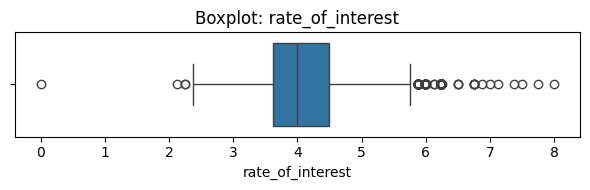

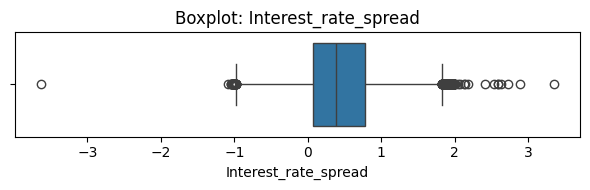

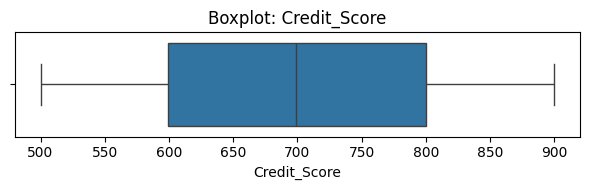

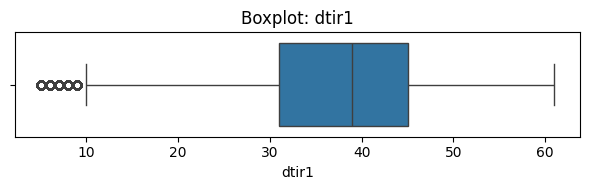

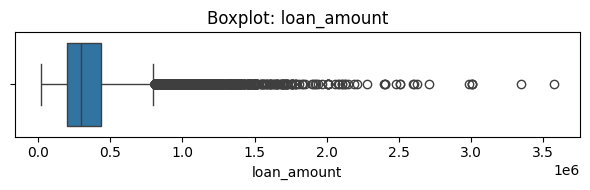

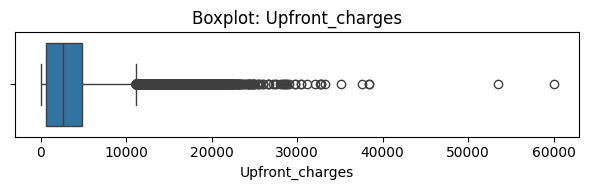

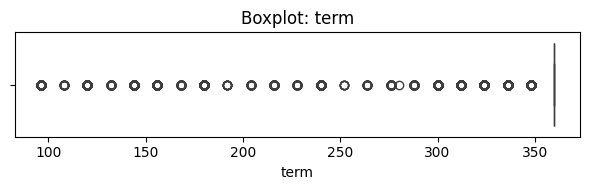

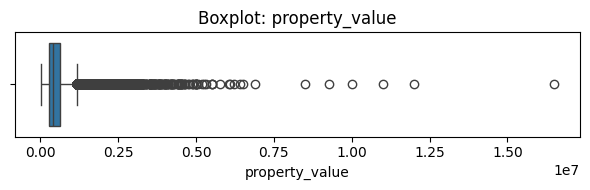

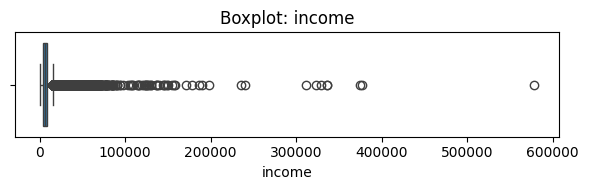

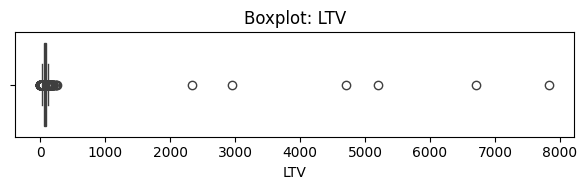

In [16]:
# ------------------------------
# 1. Visualize with Boxplots
# ------------------------------
def plot_boxplots(df, cols):
    for col in cols:
        plt.figure(figsize=(6, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

plot_boxplots(X_train, numerical_features)

In [17]:
# ------------------------------
# 2. Outlier detection using IQR
# ------------------------------
def detect_outliers_iqr(df, cols):
    outlier_dict = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_dict[col] = {
            'num_outliers': outliers.shape[0],
            'percent_outliers': round(outliers.shape[0] / df.shape[0] * 100, 2),
            'upper_cap': int(upper),
            'lower_cap': int(lower),
            'minimum': int(df[col].min()), 
            'maximum': int(df[col].max())
        }
    return pd.DataFrame(outlier_dict).T.sort_values(by='percent_outliers', ascending=False)

iqr_outliers = detect_outliers_iqr(df, numerical_features)
print("\n--- Outliers Detected by IQR ---")
print(iqr_outliers)


--- Outliers Detected by IQR ---
                      num_outliers  percent_outliers  upper_cap  lower_cap  \
term                       26944.0             18.12      360.0      360.0   
income                      6546.0              4.40    15720.0    -3480.0   
property_value              5266.0              3.54  1168000.0  -272000.0   
Upfront_charges             2880.0              1.94    11159.0    -5765.0   
dtir1                       2013.0              1.35       66.0       10.0   
loan_amount                 1895.0              1.27   796500.0  -163500.0   
LTV                         1882.0              1.27      124.0       21.0   
rate_of_interest             856.0              0.58        5.0        2.0   
Interest_rate_spread         445.0              0.30        1.0        0.0   
Credit_Score                   0.0              0.00     1101.0      297.0   

                      minimum     maximum  
term                     96.0       360.0  
income             

In [18]:
# correct the lower_cap for income, property_value, Upfront_charges, loan_amount
for col in ['income', 'property_value', 'Upfront_charges', 'loan_amount']:
    if col in iqr_outliers.index:  # check index exists
        iqr_outliers.loc[col, 'lower_cap'] = max(0, iqr_outliers.loc[col, 'lower_cap'])
print(iqr_outliers)

                      num_outliers  percent_outliers  upper_cap  lower_cap  \
term                       26944.0             18.12      360.0      360.0   
income                      6546.0              4.40    15720.0        0.0   
property_value              5266.0              3.54  1168000.0        0.0   
Upfront_charges             2880.0              1.94    11159.0        0.0   
dtir1                       2013.0              1.35       66.0       10.0   
loan_amount                 1895.0              1.27   796500.0        0.0   
LTV                         1882.0              1.27      124.0       21.0   
rate_of_interest             856.0              0.58        5.0        2.0   
Interest_rate_spread         445.0              0.30        1.0        0.0   
Credit_Score                   0.0              0.00     1101.0      297.0   

                      minimum     maximum  
term                     96.0       360.0  
income                    0.0    578580.0  
property_

term:
- Upper and lower cap are equal to maximum. This indicates that the data may be categorical in disguise. 
- Percentage of outliers is high (~18%). Normally, outliers are rare (<5%).

So let's check the unique value of term, if the number of unique value is small or discrete, consider convert it to categorical data.

In [19]:
# term
X_train['term'].value_counts()

term
360.0    97344
180.0    10324
240.0     4707
300.0     2261
324.0     2228
120.0      413
144.0      214
348.0      212
336.0      168
96.0       160
312.0      153
156.0      145
216.0       96
288.0       80
276.0       78
132.0       72
168.0       69
228.0       56
204.0       47
264.0       34
108.0       26
192.0       10
252.0        5
280.0        1
Name: count, dtype: int64

In [20]:
# For term, create binned term length.
def bin_term_binary(df):
    df = df.copy() 
    df["term"] = df["term"].map(lambda x: "long" if x == 360 else "short")
    return df
X_train_tmp = X_train.copy()
X_train_tmp = bin_term_binary(X_train_tmp)
print(X_train_tmp["term"].value_counts())
print(X_train["term"].value_counts())


term
long     97344
short    21592
Name: count, dtype: int64
term
360.0    97344
180.0    10324
240.0     4707
300.0     2261
324.0     2228
120.0      413
144.0      214
348.0      212
336.0      168
96.0       160
312.0      153
156.0      145
216.0       96
288.0       80
276.0       78
132.0       72
168.0       69
228.0       56
204.0       47
264.0       34
108.0       26
192.0       10
252.0        5
280.0        1
Name: count, dtype: int64


In [21]:
print(numerical_features_groups)

{'symmetric': ['rate_of_interest', 'Interest_rate_spread', 'Credit_Score'], 'moderate_skew': ['dtir1'], 'heavy_skew': ['loan_amount', 'Upfront_charges', 'term', 'property_value', 'income', 'LTV']}


In [22]:
if 'term' in numerical_features_groups['heavy_skew']:
    numerical_features_groups['heavy_skew'].remove('term')

numerical_features.remove('term') 
print(numerical_features)
print(numerical_features_groups)

['rate_of_interest', 'Interest_rate_spread', 'Credit_Score', 'dtir1', 'loan_amount', 'Upfront_charges', 'property_value', 'income', 'LTV']
{'symmetric': ['rate_of_interest', 'Interest_rate_spread', 'Credit_Score'], 'moderate_skew': ['dtir1'], 'heavy_skew': ['loan_amount', 'Upfront_charges', 'property_value', 'income', 'LTV']}


In [23]:
categorical_features_groups['multi_frequent'].append('term')
categorical_features.append('term')
print(categorical_features)

['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'Security_Type', 'Gender', 'loan_type', 'loan_purpose', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'term']


In [24]:
"""For ['income', 'property_value', 'Upfront_charges', 'loan_amount' ], they are highly skewed, if we use logistic model or neural network which are sensitive to feature scale and distribution,
we use cap upper bound and apply log-transform to improve skew handling.
However, if we are using tree based model, we can leave the raw values. 
We can add outlier flag to explicitly signal extreme, since it is a predictive signal (unusually high income might indicate a lower default risk)"""

def log_transform_income(df, col, iqr_outliers):
    df = df.copy()  # avoids modifying slices
    upper_cap = iqr_outliers.loc[col, 'upper_cap']
    df[col] = df[col].clip(upper=upper_cap)
    df[col] = np.log1p(df[col]).astype("float64")
    return df

def add_outlier_flag(df, col, iqr_outliers):
    df = df.copy() 
    df[col+'_outlier_flag'] = np.where(
    df[col].isna(),
    0,
    (df[col] > iqr_outliers.loc[col, 'upper_cap']).astype(int))
    return df
    

In [25]:
LTV_cap_value = 250
print(f"number of rows that LTV > 250: {len(X_train[X_train['LTV']>LTV_cap_value])}")

number of rows that LTV > 250: 7


Since LTV above 200–250 is almost always unrealistic, so values >250 are almost certainly errors and should be corrected or removed rather than used in modeling. Also, only 7 rows are extreme and wrong, simply remove them.

In [26]:
def drop_invalid_LTV(X, y, threshold=250):
    original_count = len(X)
    print("original_count", original_count)
    mask = X['LTV'] > threshold
    filtered_X = X.loc[~mask].copy()
    filtered_y = y.loc[~mask].copy()
    print('filtered length: ', len(filtered_X))
    dropped_count = original_count - len(filtered_X)
    print(f"Dropped {dropped_count} rows where LTV > {threshold}")
    return filtered_X, filtered_y

X_train, y_train = drop_invalid_LTV(X_train, y_train, threshold=1000)
print(X_train.shape)

original_count 118936
filtered length:  118930
Dropped 6 rows where LTV > 1000
(118930, 31)


In [27]:
X_train.term.value_counts()

term
360.0    97338
180.0    10324
240.0     4707
300.0     2261
324.0     2228
120.0      413
144.0      214
348.0      212
336.0      168
96.0       160
312.0      153
156.0      145
216.0       96
288.0       80
276.0       78
132.0       72
168.0       69
228.0       56
204.0       47
264.0       34
108.0       26
192.0       10
252.0        5
280.0        1
Name: count, dtype: int64

In [ ]:

outlier_processing_lr_nn ={'term': [bin_term_binary],
                            'LTV': [log_transform_income, add_outlier_flag], 
                            'income': [log_transform_income, add_outlier_flag], 
                            'property_value': [log_transform_income, add_outlier_flag], 
                            'Upfront_charges': [log_transform_income, add_outlier_flag], 
                            'loan_amount': [log_transform_income, add_outlier_flag]}

outlier_processing_tree ={'LTV': add_outlier_flag, 
                            'term': bin_term_binary,
                            'income': [add_outlier_flag], 
                            'property_value': [add_outlier_flag], 
                            'Upfront_charges': [add_outlier_flag], 
                            'loan_amount': [add_outlier_flag]}

In [ ]:
def apply_preprocess(df, outlier_processing, iqr_outliers=None, verbose=True):
    """
    Apply preprocessing functions to a DataFrame according to rules.

    Args:
        df: pandas DataFrame
        outlier_processing: dictionary of preprocess rules (like outlier_processing_lr_nn)
        iqr_outliers: DataFrame with outlier info from training data
        verbose: whether to print logging info

    Returns:
        df: processed DataFrame
    """
    for col, funcs in outlier_processing.items():
        if not isinstance(funcs, list):
            funcs = [funcs]
        
        for func in funcs:
            # Function takes only df
            if func.__code__.co_argcount == 1:
                df = func(df)
                print(col)
            # Function takes df, col, iqr_outliers
            elif func.__code__.co_argcount >= 2:
                if verbose and col in iqr_outliers.index:
                    upper = iqr_outliers.loc[col, 'upper_cap']
                    pct_out = iqr_outliers.loc[col, 'percent_outliers']
                    print(f"[{col}] Applying {func.__name__}: {pct_out}% outliers, upper cap={upper}")
                df = func(df, col, iqr_outliers)
            else:
                raise ValueError(f"Cannot determine arguments for function {func.__name__}")
    if verbose:
        print("Preprocessing completed.\n")
    return df



In [ ]:
# Logistic/NN model preprocessing
X_train_lr_nn = apply_preprocess(X_train.copy(), outlier_processing_lr_nn, iqr_outliers)
X_test_lr_nn  = apply_preprocess(X_test.copy(), outlier_processing_lr_nn, iqr_outliers)

# # Tree-based model preprocessing
# X_train_tree = apply_preprocess(X_train.copy(), outlier_processing_tree, iqr_outliers)
# X_test_tree  = apply_preprocess(X_test.copy(), outlier_processing_tree, iqr_outliers)

term
[LTV] Applying log_transform_income: 1.27% outliers, upper cap=124.0
[LTV] Applying add_outlier_flag: 1.27% outliers, upper cap=124.0
[income] Applying log_transform_income: 4.4% outliers, upper cap=15720.0
[income] Applying add_outlier_flag: 4.4% outliers, upper cap=15720.0
[property_value] Applying log_transform_income: 3.54% outliers, upper cap=1168000.0
[property_value] Applying add_outlier_flag: 3.54% outliers, upper cap=1168000.0
[Upfront_charges] Applying log_transform_income: 1.94% outliers, upper cap=11159.0
[Upfront_charges] Applying add_outlier_flag: 1.94% outliers, upper cap=11159.0
[loan_amount] Applying log_transform_income: 1.27% outliers, upper cap=796500.0
[loan_amount] Applying add_outlier_flag: 1.27% outliers, upper cap=796500.0
Preprocessing completed.

term
[LTV] Applying log_transform_income: 1.27% outliers, upper cap=124.0
[LTV] Applying add_outlier_flag: 1.27% outliers, upper cap=124.0
[income] Applying log_transform_income: 4.4% outliers, upper cap=15720.0

## 1.6 Missing Values

Upfront_charges              0.267351
Interest_rate_spread         0.247187
rate_of_interest             0.245893
dtir1                        0.162961
LTV                          0.101951
property_value               0.101951
income                       0.061894
loan_limit                   0.022719
approv_in_adv                0.005995
age                          0.001295
submission_of_application    0.001295
loan_purpose                 0.000942
Neg_ammortization            0.000816
dtype: float64


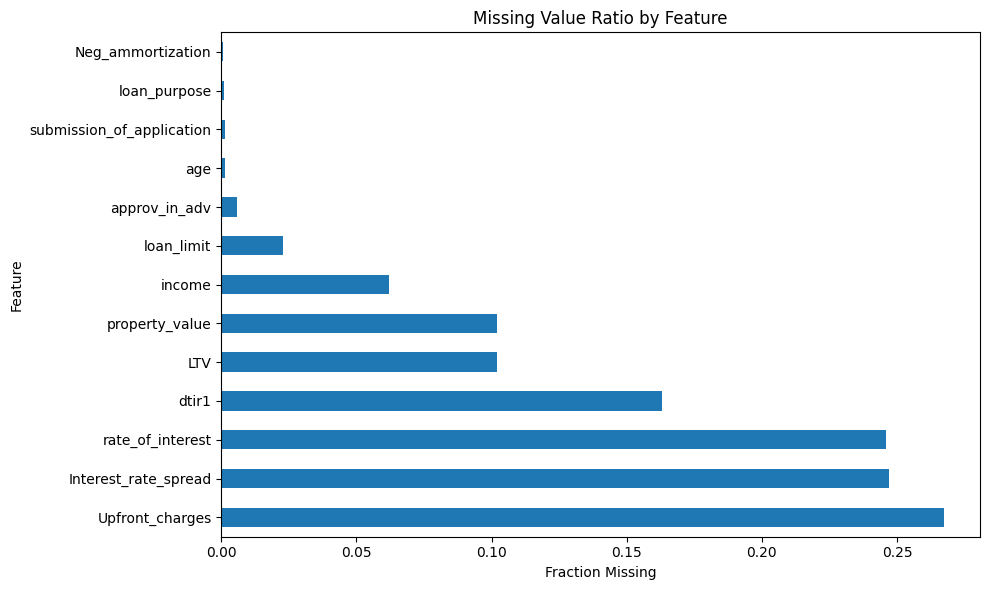

['Upfront_charges', 'Interest_rate_spread', 'rate_of_interest']


In [31]:
def calculate_missing_ratio(df): 
    # Calculate the proportion of missing values
    missing_ratio = df.isnull().mean().sort_values(ascending=False)

    # Display only columns with missing values
    missing_ratio = missing_ratio[missing_ratio > 0]
    print(missing_ratio)

    # Plot missing value ratio
    plt.figure(figsize=(10, 6))
    missing_ratio.plot(kind='barh')
    plt.title("Missing Value Ratio by Feature")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return missing_ratio
missing_ratio = calculate_missing_ratio(X_train_lr_nn)
threshold = 0.2

# Get columns with high missing ratio
high_missing_ratio_features = missing_ratio[missing_ratio > threshold].index.tolist()
print(high_missing_ratio_features)


## 1.7 Feature Importance

(118930, 36)
(118930,)
                         feature  importance
10          Interest_rate_spread    0.395795
11               Upfront_charges    0.239712
9               rate_of_interest    0.190297
27                           LTV    0.039561
22                   credit_type    0.030783
16                property_value    0.026958
30                         dtir1    0.023621
21                        income    0.007686
24      co-applicant_credit_type    0.006579
7         business_or_commercial    0.006239
13             Neg_ammortization    0.006198
15              lump_sum_payment    0.005024
26     submission_of_application    0.004775
8                    loan_amount    0.004454
3                      loan_type    0.003175
4                   loan_purpose    0.001253
1                         Gender    0.001204
12                          term    0.001147
23                  Credit_Score    0.001011
18                occupancy_type    0.000837
0                     loan_limit

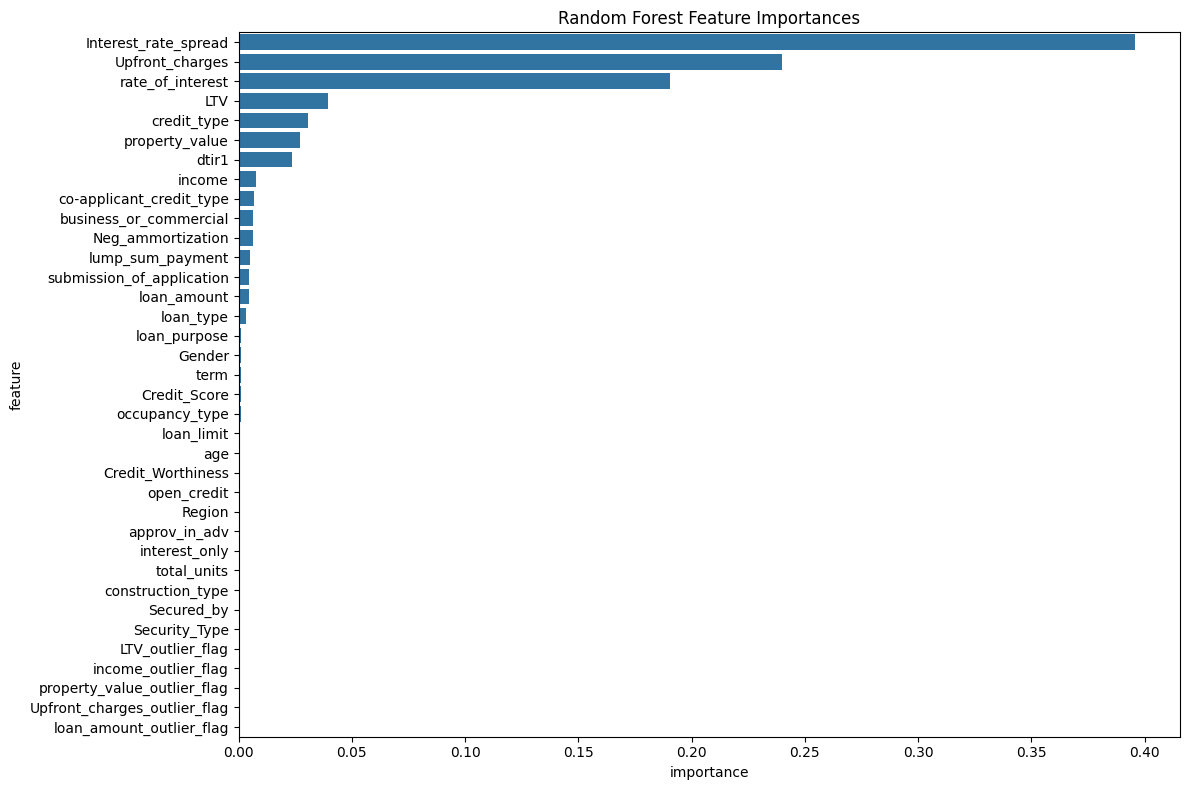

In [32]:
def calculate_feature_importance(X, y):
    # Copy the original dataframe
    X_temp = X.copy()
    print(X.shape)
    print(y.shape)
    # Encode categorical columns and impute missing values
    features = X_temp.columns
    for col in features:
        if X_temp[col].dtype == 'object' or X_temp[col].dtype.name == 'category':
            X_temp[col] = X_temp[col].fillna(X_temp[col].mode()[0])  # Fill with most frequent
            le = LabelEncoder()
            X_temp[col] = le.fit_transform(X_temp[col])
        else:
            X_temp[col] = X_temp[col].fillna(X_temp[col].median())  # Fill with median

    # Prepare data
 

    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Extract feature importances
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Print or display
    print(feature_importances)

    # Optional: plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importances, y='feature', x='importance')
    plt.title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    return feature_importances


feature_importances = calculate_feature_importance(X_train_lr_nn, y_train)

In [33]:
# Get features with low importance
threshold = 0.005
low_importance = feature_importances[feature_importances['importance'] < threshold]
print("Features below importance threshold:")
print(low_importance.feature)

Features below importance threshold:
26       submission_of_application
8                      loan_amount
3                        loan_type
4                     loan_purpose
1                           Gender
12                            term
23                    Credit_Score
18                  occupancy_type
0                       loan_limit
25                             age
5                Credit_Worthiness
6                      open_credit
28                          Region
2                    approv_in_adv
14                   interest_only
20                     total_units
17               construction_type
19                      Secured_by
29                   Security_Type
31                LTV_outlier_flag
32             income_outlier_flag
33     property_value_outlier_flag
34    Upfront_charges_outlier_flag
35        loan_amount_outlier_flag
Name: feature, dtype: object


In [34]:
# Get features with high importance
threshold = 0.05
high_importance = feature_importances[feature_importances['importance'] >= threshold]
print("Features above importance threshold:")
high_importance_features = high_importance.feature.to_list()
print(high_importance_features)

Features above importance threshold:
['Interest_rate_spread', 'Upfront_charges', 'rate_of_interest']


Principle of handling missing values:
Understand missingness first (MCAR, MAR, MNAR) — it informs whether simple imputation is unbiased.

Use feature importance as a secondary guide — focus computational effort on predictive features.

High-cardinality features → avoid naive one-hot; use target encoding or embeddings.

Iterative/tree-based imputation works well for numeric + low-cardinality features.

MNAR is tricky — treat missing as special category if unsure.

## 2.1 Check MCAR/MAR/MNAR


- **MCAR**: missing completely at random.
    - simple imputation is fine.
- **MAR**: missing at random.
    - model-based imputation is preferable.
- **MNAR**: missing NOT at random.
    - sometimes use a “Missing” category or model missingness explicitly.

For each column with missing values:
- Run t-test / chi2 against all other columns
- If all p-values > 0.05 → treat as MCAR
- Else → treat as MAR
- If domain knowledge suggests missingness depends on its own value → treat as MNAR
- Sample sizes matter: If there are very few missing rows, t-test or chi2 may be underpowered → may falsely appear as MCAR.

In [35]:
def mcar_mar_analysis(df):
    MCAR = []  # list of columns consistent with MCAR
    not_mcar = {}  # dict: col -> list of other_cols with significant dependence

    for col in df.columns:
        if df[col].isnull().sum() == 0:
            continue  # skip columns with no missing values

        missing_mask = df[col].isnull()
        dependent_cols = []

        for other_col in df.columns:
            if other_col == col:
                continue

            # Numerical other_col → t-test
            if pd.api.types.is_numeric_dtype(df[other_col]):
                sample1 = df.loc[missing_mask, other_col].dropna()
                sample2 = df.loc[~missing_mask, other_col].dropna()
                if len(sample1) > 0 and len(sample2) > 0:
                    _, p_val = ttest_ind(sample1, sample2, equal_var=False)
                    if p_val <= 0.05:
                        dependent_cols.append(other_col)

            # Categorical other_col → chi2 test
            else:
                contingency = pd.crosstab(df[other_col], missing_mask)
                if contingency.shape[0] > 0 and contingency.shape[1] > 0:
                    _, p_val, _, _ = chi2_contingency(contingency)
                    if p_val <= 0.05:
                        dependent_cols.append(other_col)

        # Decide MCAR or MAR
        if len(dependent_cols) == 0:
            MCAR.append(col)
        else:
            not_mcar[col] = dependent_cols

    return MCAR, not_mcar

MCAR, not_mcar = mcar_mar_analysis(X_train)
print("MCAR columns:", MCAR)
print("Columns with missingness depending on other columns (MAR):", not_mcar)

MCAR columns: []
Columns with missingness depending on other columns (MAR): {'loan_limit': ['approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type', 'co-applicant_credit_type', 'age', 'LTV', 'Region'], 'approv_in_adv': ['loan_limit', 'loan_purpose', 'Credit_Worthiness', 'loan_amount', 'rate_of_interest', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type', 'total_units', 'submission_of_application'], 'loan_purpose': ['approv_in_adv', 'loan_type', 'Credit_Worthiness', 'business_or_commercial', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'interest_only', 'property_value', 'total_units', 'credit_type', 'age', 'submission_of_application', 'LTV'], 'rate_of_interest': ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type'

## 2.2 Imputer for missing values
- Numerical Features:
    - High-importance features: Tree-based IterativeImputer (estimator=RandomForest)
    - Others: Symmetric -> mean; Skewed -> median

- Categorical Features:
    - One dominant -> mode; Multi frequent -> frequency-based encoding; High cardinality -> Out-of-fold target encoding.


In [36]:
print(high_importance_features)

['Interest_rate_spread', 'Upfront_charges', 'rate_of_interest']


In [37]:
# High importance features: Tree-based iterative imputer
high_imp_numeric = [f for f in high_importance_features if f in numerical_features]
high_imp_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #IterativeImputer(estimator=RandomForestRegressor(), random_state=42)),
    ('scaler', StandardScaler())
])

# Symmetric features (mean)
symmetric_numeric = [f for f in numerical_features_groups['symmetric'] if f not in high_imp_numeric]
symmetric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Skewed features (median)
moderate_skew_numeric = [f for f in numerical_features_groups['moderate_skew'] if f not in high_imp_numeric]
moderate_skew_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

heavy_skew_numeric = [f for f in numerical_features_groups['heavy_skew'] if f not in high_imp_numeric]
heavy_skew_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [38]:
#Preprocessing pipelines for categorical features
# One dominant: mode
one_dominant_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Multi frequent: frequency-based
# Implement frequency encoding manually
def frequency_encoder(X):
    # If X is a NumPy array, convert it to DataFrame
    if isinstance(X, np.ndarray):
        # The column names must match what ColumnTransformer passed
        # For example, using the multi_frequent categorical columns
        X = pd.DataFrame(X, columns=categorical_features_groups['multi_frequent'])
    X = X.copy()
    for col in X.columns:
        freq = X[col].value_counts() / len(X)
        X[col] = X[col].map(freq)
    return X

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing first
    ('freq', FunctionTransformer(frequency_encoder, validate=False))
])



In [39]:
class LeakageSafeTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, n_splits=5, random_state=42):
        self.cols = cols
        self.n_splits = n_splits
        self.random_state = random_state
        self.final_encoder_ = None
        self.oof_encoded_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).reset_index(drop=True)
        if self.cols is None:
            self.cols = X.columns.tolist()

        self.oof_encoded_ = pd.DataFrame(index=X.index, columns=self.cols)
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for train_idx, val_idx in kf.split(X):
            encoder = TargetEncoder(cols=self.cols)
            encoder.fit(X.iloc[train_idx], y.iloc[train_idx])
            self.oof_encoded_.iloc[val_idx] = encoder.transform(X.iloc[val_idx])[self.cols]

        # Fit final encoder on full training data to use during .transform()
        self.final_encoder_ = TargetEncoder(cols=self.cols)
        self.final_encoder_.fit(X, y)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        if self.final_encoder_ is None:
            raise ValueError("You must call fit before transform.")
        return self.final_encoder_.transform(X)[self.cols]
    
high_card_transformer = Pipeline(steps=[
    ('target_enc', LeakageSafeTargetEncoder(cols=['your_high_card_col']))
])

In [40]:
preprocessor = ColumnTransformer(transformers=[
    ('high_imp_num', high_imp_transformer, high_imp_numeric),
    ('symmetric_num', symmetric_transformer, symmetric_numeric),
    ('mod_skew_num', moderate_skew_transformer, moderate_skew_numeric),
    ('heavy_skew_num', heavy_skew_transformer, heavy_skew_numeric),
    ('one_dom_cat', one_dominant_transformer, categorical_features_groups['one_dominant']),
    ('multi_freq_cat', one_dominant_transformer, categorical_features_groups['multi_frequent'])#,
    #('high_card_cat', high_card_transformer, categorical_features_groups['high_cardinality'])
])

# 3. Train a Model
Since it is a binary classification problem, use models like
- Logistic Regression.
- Random Forest.
- XGBoost.

In [41]:

param_grid = {
    'classifier__n_estimators': [100],#, 200],
    'classifier__max_depth': [None, 10],#, 20],
    'classifier__min_samples_split': [2],#, 5],
    'classifier__min_samples_leaf': [1],#, 2]
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # use AUC for imbalanced data
    return_train_score=True,
    n_jobs=-1
)


In [45]:
import joblib
from joblib import parallel_backend
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Monkey-patch joblib with tqdm
# Patch joblib to show tqdm progress
class TqdmJoblib(joblib.Parallel):
    def __init__(self, total=None, *args, **kwargs):
        self._total = total
        self._pbar = tqdm(total=total, desc="GridSearchCV Progress")
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with self._pbar:
            return super().__call__(*args, **kwargs)

    def print_progress(self):
        if self._pbar:
            self._pbar.n = self.n_completed_tasks
            self._pbar.refresh()

# Compute total fits = param combos × CV folds
n_candidates = len(list(ParameterGrid(param_grid)))
n_folds = cv.get_n_splits()
total_fits = n_candidates * n_folds

# Run search with progress bar
with parallel_backend('loky'):
    grid_search._parallel_backend = TqdmJoblib(n_jobs=-1, total=total_fits)
    grid_search.fit(X_train_lr_nn, y_train)

GridSearchCV Progress:   0%|          | 0/4 [07:33<?, ?it/s]


# 4. Evaluate the Model.
Metrics include 
- Accuracy.
- Precision, Recall, F1-score.
- PR-AUC/ROC-AUC.


In [43]:
print("Best parameters found:", grid_search.best_params_)
print("Best CV score (AUC):", grid_search.best_score_)

# Training metrics
train_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
print(train_results)

Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV score (AUC): 1.0
                                              params  mean_train_score  \
0  {'classifier__max_depth': None, 'classifier__m...               1.0   
1  {'classifier__max_depth': 10, 'classifier__min...               1.0   

   mean_test_score  
0              1.0  
1              1.0  


# 5. Evaluate on test set

In [44]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Test Accuracy: 1.0
Test ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22494
           1       1.00      1.00      1.00      7240

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



# 6. Save model parameters and metadata for deployment.

In [ ]:
# save metadata
feature_groups = {
    "high_imp_numeric": high_imp_numeric,
    "numerical_features_groups": numerical_features_groups,
    "categorical_features_groups": categorical_features_groups
}
joblib.dump({
    "iqr_outliers": iqr_outliers,
    "feature_groups": feature_groups,
    "outlier_processing": outlier_processing_lr_nn
}, "preprocessing_metadata.pkl")

In [ ]:
# save the entire best pipeline (preprocessing + model)